Zillow Project

# Requirements and Planning

a. Write a SQL query to retreive data from the zillow database

b. figure out state and county taxes for each property

c. County "hot months" May and June

URL for FIPS data:
https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697

In [1]:
import os.path

import pandas as pd
import numpy as np


import acquire
import env
import evaluate
import prep

import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.model_selection
import sklearn.feature_selection
import seaborn as sns
import warnings

from math import sqrt
from scipy import stats
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import explained_variance_score as evs
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.formula.api import ols

%matplotlib inline

# limit all floats to 3 decimal places
pd.options.display.float_format = '{:.3f}'.format
warnings.filterwarnings('ignore')

# Acquire the Data
- call acquire_data() method from the acquire.py
- acquire.acquire_data() connects to the codeup_db
- runs a sql script to acquire the zillow data
- the code below stores it into a dataframe

In [2]:
df = acquire.acquire_data()
df

Acquiring data ...

- csv already exist

Data has been acquired


,bedroom_count,bathroom_count,total_sqft,tax_property_value,tax_amount,fips,county,state
0,2.000,3.000,1458.000,136104.000,2319.900,6037.000,Los Angeles,CA
1,1.000,2.000,1421.000,35606.000,543.690,6037.000,Los Angeles,CA
2,2.000,3.000,1650.000,614000.000,7673.190,6037.000,Los Angeles,CA
3,1.000,2.000,693.000,274237.000,3267.470,6037.000,Los Angeles,CA
4,0.000,0.000,1378.000,168828.000,2135.390,6037.000,Los Angeles,CA
...,...,...,...,...,...,...,...,...
15031,2.000,3.000,1575.000,506000.000,5417.500,6111.000,Ventura,CA
15032,2.000,3.000,1645.000,230986.000,2855.780,6111.000,Ventura,CA
15033,2.000,3.000,1308.000,255407.000,2788.680,6111.000,Ventura,CA
15034,2.500,4.000,2314.000,485364.000,9549.080,6111.000,Ventura,CA


# Prepair the Data
- call clean_df() method from the prep.py
- prep.clean_df() receives the zillow dataframe
- averages out any empty bathroom or bedroom count
- drops an row that is null
- calculates the tax rate for each property
- sets all fips to integer type

### Clean the data
*~ see README.md*

In [3]:
df = prep.clean_df(df)
df

Cleaning data ...

- bathroom and bedroom 0 counts corrected by the df.mean() for each.
- dropped all rows containing a null
- created tax_rate column

Zillow_df cleaned and ready for exploration


,bedroom_count,bathroom_count,total_sqft,tax_property_value,tax_amount,county,state,tax_rate
0,2.000,3.000,1458.000,136104.000,2319.900,Los Angeles,CA,0.017
1,1.000,2.000,1421.000,35606.000,543.690,Los Angeles,CA,0.015
2,2.000,3.000,1650.000,614000.000,7673.190,Los Angeles,CA,0.012
3,1.000,2.000,693.000,274237.000,3267.470,Los Angeles,CA,0.012
4,2.000,3.000,1378.000,168828.000,2135.390,Los Angeles,CA,0.013
...,...,...,...,...,...,...,...,...
15031,2.000,3.000,1575.000,506000.000,5417.500,Ventura,CA,0.011
15032,2.000,3.000,1645.000,230986.000,2855.780,Ventura,CA,0.012
15033,2.000,3.000,1308.000,255407.000,2788.680,Ventura,CA,0.011
15034,2.500,4.000,2314.000,485364.000,9549.080,Ventura,CA,0.020


In [4]:
# prep.clean_df?

In [5]:
df.describe()

,bedroom_count,bathroom_count,total_sqft,tax_property_value,tax_amount,tax_rate
count,15011.000,15011.000,15011.000,15011.000,15011.000,15011.000
mean,2.328,3.317,1942.110,541332.729,6593.327,0.013
std,1.019,0.936,1001.673,730626.381,8449.893,0.007
min,1.000,1.000,300.000,10504.000,51.260,0.001
25%,2.000,3.000,1275.000,198596.000,2706.520,0.012
50%,2.000,3.000,1679.000,384886.000,4771.470,0.012
75%,3.000,4.000,2346.000,644944.000,7678.315,0.014
max,11.000,12.000,15450.000,23858374.000,276797.830,0.453


In [6]:
# create county_tax_property_value_mean series
county_tax_property_value_mean = prep.get_county_tax_property_value_mean(df)
county_tax_property_value_mean

county
Los Angeles   514347.380
Orange        617291.600
Ventura       501542.397
Name: tax_property_value, dtype: float64

In [7]:
# create county_tax_rate_mean dataframe
county_tax_rate_mean = prep.get_county_tax_rate_mean(df, county_tax_property_value_mean)
county_tax_rate_mean

,county,tax_rate,county_tax_property_value_mean
0,Los Angeles,0.014,514347.380
1,Orange,0.012,617291.600
2,Ventura,0.012,501542.397


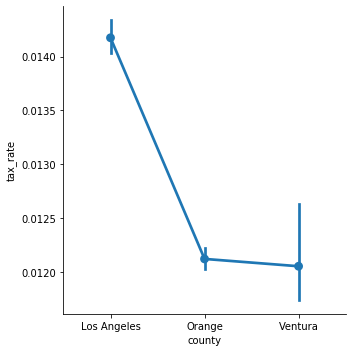

In [8]:
sns.catplot(x='county', y='tax_rate',kind="point", data=df)
plt.show()

## Train Test Split

In [9]:
train, test = sklearn.model_selection.train_test_split(df, train_size=.8, random_state=22)
print(train.shape)
print(test.shape)

(12008, 8)
(3003, 8)


In [10]:
train

,bedroom_count,bathroom_count,total_sqft,tax_property_value,tax_amount,county,state,tax_rate
988,2.000,3.000,1334.000,254856.000,4517.160,Los Angeles,CA,0.018
6266,2.000,4.000,2000.000,618178.000,7242.770,Los Angeles,CA,0.012
5576,2.000,4.000,2179.000,390559.000,4861.520,Los Angeles,CA,0.012
7553,1.000,3.000,984.000,289508.000,3516.440,Los Angeles,CA,0.012
5464,3.000,4.000,1876.000,437676.000,5327.590,Los Angeles,CA,0.012
...,...,...,...,...,...,...,...,...
5482,4.000,5.000,2771.000,157153.000,1988.410,Los Angeles,CA,0.013
8555,3.000,3.000,2085.000,1085000.000,13035.450,Los Angeles,CA,0.012
13122,3.000,4.000,3850.000,975915.000,11684.800,Orange,CA,0.012
6282,4.000,5.000,3048.000,964487.000,11723.370,Los Angeles,CA,0.012


# Explore the data

## My Hypotheses:¶

- bathroom_count correlates with the tax_property_value
- bedroom_count correlates with the tax_property_value
- sqft correlates with the tax_property_value
- the values for bathroom_count, bedroom_count, and sqft probably correlate with eachother
- my own hypothesis is that all three have the strongest correlation with the tax_property_value

- $H_0$:  there is no linear correlation between any of the values and tax_property_value
- $H_a1$: the greatest correlation is between bathroom count and tax_property_value
- $H_a2$: the greatest correlation is between bedroom count and tax_property_value
- $H_a3$: the greatest correlation is between square feet and tax_property_value
- $H_a4$: the greatest correlation is between all three and tax_property_value


pearson-r linear
RMSE

# Eval

# Modeling

In [11]:
predictions = pd.DataFrame({
    'county': train.county,
    'actual': train.tax_property_value
})

In [12]:
# change first three to little x
X_bathrm_count = train[['bathroom_count']]
X_bedrm_count = train[['bedroom_count']]
X_sqft = train[['total_sqft']]
X_all_three = train[['bathroom_count', 'bedroom_count', 'total_sqft']]


y = train.tax_property_value

## Simple Regression
- Applied to bathroom_count, bedroom_count, and sqft

In [13]:
lm = sklearn.linear_model.LinearRegression()

In [14]:
bathroom_lm = lm.fit(X_bathrm_count, y)
predictions['bathroom_ct_lm'] = bathroom_lm.predict(X_bathrm_count)

bedroom_lm = lm.fit(X_bedrm_count, y)
predictions['bedroom_ct_lm'] = bedroom_lm.predict(X_bedrm_count)

sqft_lm = lm.fit(X_sqft, y)
predictions['sqft_lm'] = sqft_lm.predict(X_sqft)

all_three_lm = lm.fit(X_all_three, y)
predictions['all_three_lm'] = all_three_lm.predict(X_all_three)

In [15]:
predictions

,county,actual,bathroom_ct_lm,bedroom_ct_lm,sqft_lm,all_three_lm
988,Los Angeles,254856.000,470487.075,417382.206,268270.438,272295.557
6266,Los Angeles,618178.000,697623.627,417382.206,568335.636,454580.980
5576,Los Angeles,390559.000,697623.627,417382.206,648983.789,542933.035
7553,Los Angeles,289508.000,470487.075,36932.716,110578.518,49511.785
5464,Los Angeles,437676.000,697623.627,797831.696,512467.641,443404.562
...,...,...,...,...,...,...
5482,Los Angeles,157153.000,924760.179,1178281.186,915708.409,788749.742
8555,Los Angeles,1085000.000,470487.075,797831.696,606632.245,693007.675
13122,Orange,975915.000,697623.627,797831.696,1401850.073,1417745.102
6282,Los Angeles,964487.000,924760.179,1178281.186,1040510.300,925473.313


### Simple Regression Visuals

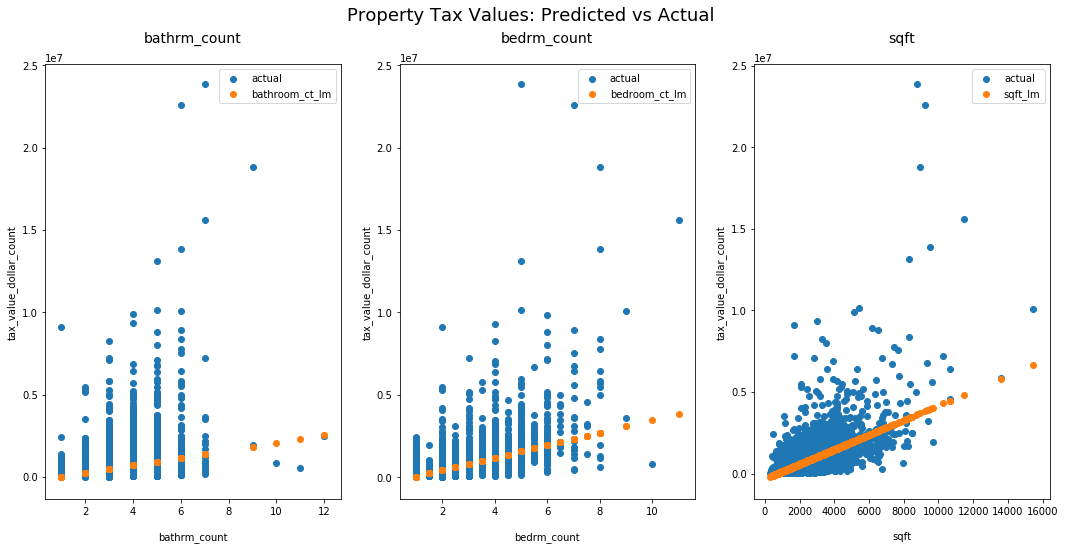

In [16]:
plt.figure(figsize=(18,8))
plt.suptitle('Property Tax Values: Predicted vs Actual\n', fontsize=18)

# Figure 1
plt.subplot(1, 3, 1)
plt.title('bathrm_count\n', fontsize=14)
plt.scatter(X_bathrm_count, predictions.actual, label='actual')
plt.scatter(X_bathrm_count, predictions.bathroom_ct_lm, label='bathroom_ct_lm')
plt.xlabel('\nbathrm_count')
plt.ylabel('tax_value_dollar_count')
plt.legend()

# Figure 2
plt.subplot(1, 3, 2)
plt.title('bedrm_count\n', fontsize=14)
plt.scatter(X_bedrm_count, predictions.actual, label='actual')
plt.scatter(X_bedrm_count, predictions.bedroom_ct_lm, label='bedroom_ct_lm')
plt.xlabel('\nbedrm_count')
plt.ylabel('tax_value_dollar_count')
plt.legend()

# Figure 3
plt.subplot(1, 3, 3)
plt.title('sqft\n', fontsize=14)
plt.scatter(X_sqft, predictions.actual, label='actual')
plt.scatter(X_sqft, predictions.sqft_lm, label='sqft_lm')
plt.xlabel('\nsqft')
plt.ylabel('tax_value_dollar_count')
plt.legend()

plt.show()

In [17]:
MSE_Bath = mse(predictions.actual, predictions.bathroom_ct_lm)
MSE_Bed = mse(predictions.actual, predictions.bedroom_ct_lm)
MSE_SqFt = mse(predictions.actual, predictions.sqft_lm)

In [18]:
MSE_Bath, MSE_Bed, MSE_SqFt

(527480340285.13135, 421111379334.9113, 365615894424.06714)

In [19]:
bath_n_bed = train[['bathroom_count', 'bedroom_count']]
bath_n_sqft = train[['bathroom_count', 'total_sqft']]
bed_n_sqft = train[['bedroom_count', 'total_sqft']]
all_three = train[['bathroom_count', 'bedroom_count', 'total_sqft']]

In [20]:
predictions

,county,actual,bathroom_ct_lm,bedroom_ct_lm,sqft_lm,all_three_lm
988,Los Angeles,254856.000,470487.075,417382.206,268270.438,272295.557
6266,Los Angeles,618178.000,697623.627,417382.206,568335.636,454580.980
5576,Los Angeles,390559.000,697623.627,417382.206,648983.789,542933.035
7553,Los Angeles,289508.000,470487.075,36932.716,110578.518,49511.785
5464,Los Angeles,437676.000,697623.627,797831.696,512467.641,443404.562
...,...,...,...,...,...,...
5482,Los Angeles,157153.000,924760.179,1178281.186,915708.409,788749.742
8555,Los Angeles,1085000.000,470487.075,797831.696,606632.245,693007.675
13122,Orange,975915.000,697623.627,797831.696,1401850.073,1417745.102
6282,Los Angeles,964487.000,924760.179,1178281.186,1040510.300,925473.313


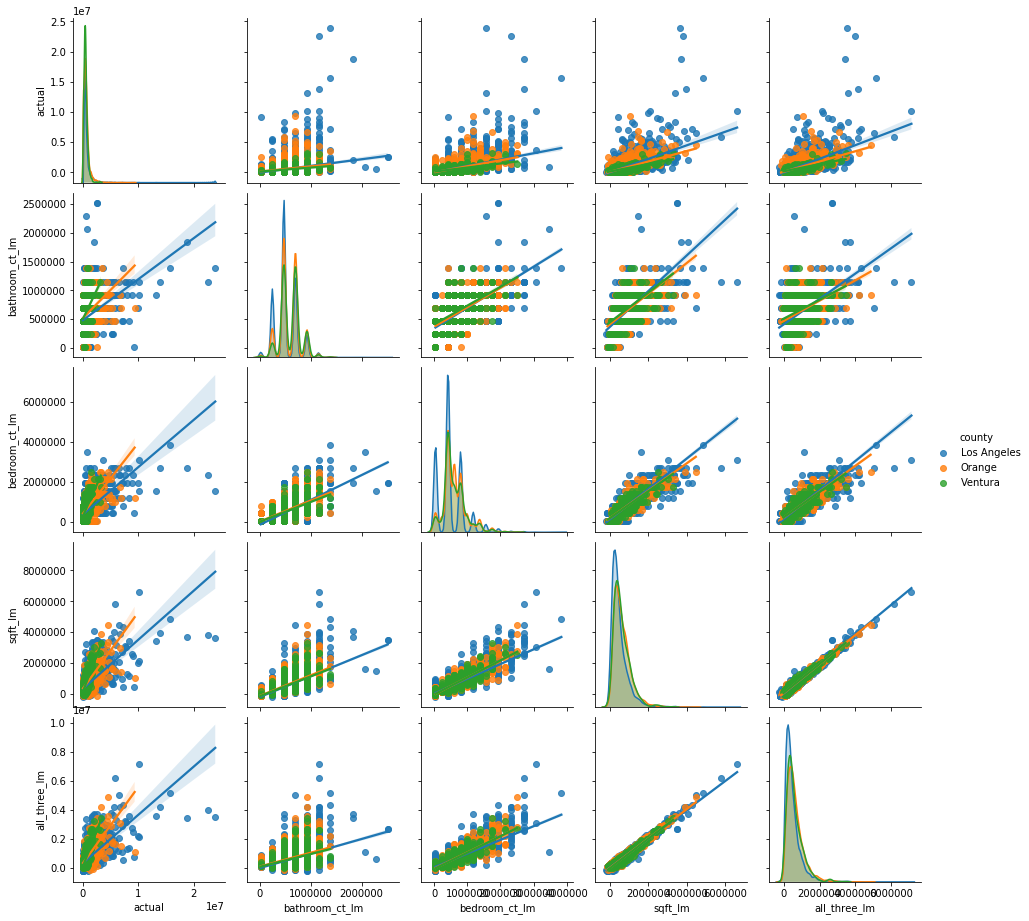

In [21]:
sns.pairplot(predictions, kind='reg', hue='county')

(0, 4)

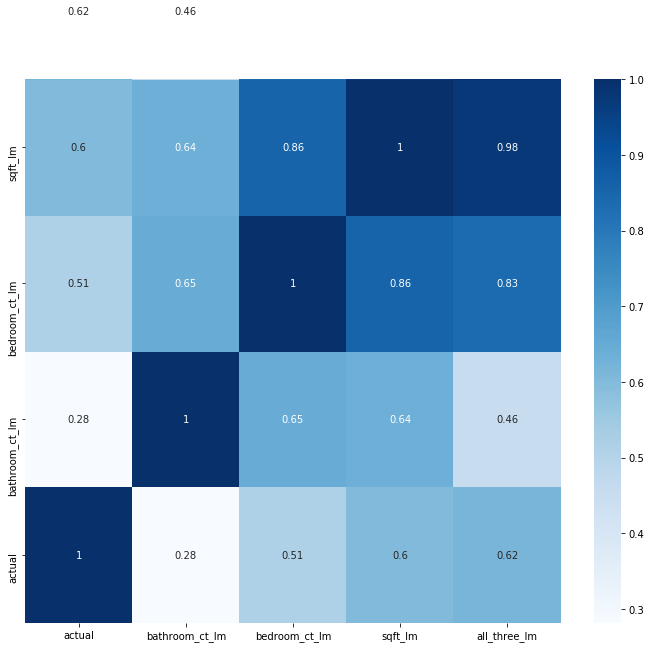

In [22]:
plt.figure(figsize=(12,10))
sns.heatmap(predictions.corr(), cmap='Blues', annot=True)
plt.ylim(0, 4)

# Evaluating

In [23]:
plot_residuals(y, yhat, df)

NameError: name 'plot_residuals' is not defined